# First stage of an academic OSIOSN project 
### OSIOSN - ENG: Optimization Of Structures And Calculations in Neural Networks
### Downloading APNEA dataset from physionet

In [ ]:
# Windows
! wget -r -N -c -np https://physionet.org/files/apnea-ecg/1.0.0/ 

# Ubuntu
# ! apt update && apt install wget
# ! wget -r -N -c -np https://physionet.org/files/apnea-ecg/1.0.0/ 



### Libraries and constants for this notebook

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import wfdb
import neurokit2 as nk
from customLib.preprocess import *
from customLib.peak_detection import *
from customLib.vis import plot_ecg

In [2]:
DATASET_PATH = "E:\\ml-data\\masters-thesis\\physionet.org\\files\\apnea-ecg\\1.0.0"
PREPROCESSED_DATASET_PATH = "./preprocessed"
FINAL_DATASET_PATH = "./dataset"
FS = 100 # sampling frequency

In [3]:
# Read all ECG and split signal into smaller windows

def preprocess_apnea_dataset(dataset_path="./physionet.org/files/apnea-ecg/1.0.0"):
  # Gather only the files with .dat extension

  if not (os.path.isdir(PREPROCESSED_DATASET_PATH)):
    print("Creating target directory...\n")
    os.mkdir(PREPROCESSED_DATASET_PATH)

  print("Looking for ECG files...\n")
  files = []

  for file in os.listdir(DATASET_PATH):
    if file.endswith(".dat") & (not file.endswith("r.dat")): # do not read respiratory data
      files.append(file.split(".")[0])

  ecgList = []
  print(f"Total files to process: {len(files)}\n")
  
  for file_idx in tqdm(range(len(files))):
    record = wfdb.rdrecord(os.path.join(DATASET_PATH , files[file_idx]))
    signal = record.p_signal.flatten()

    assert record.fs == FS

    ecg_windows = split_signal(signal=signal, fs=FS, overlap_factor=0.0)
    for window in ecg_windows:
      ecg_window = dwt_denoise(signal=window)
      ecgList.append(ecg_window)

  ecgList = np.array(ecgList)

  print(f"Saving preprocessed ECGs to {PREPROCESSED_DATASET_PATH}")
  np.save(os.path.join(PREPROCESSED_DATASET_PATH,"ECGs.npy"), ecgList)
  return ecgList


In [4]:
ECGs = preprocess_apnea_dataset(DATASET_PATH)

Looking for ECG files...

Total files to process: 70



100%|██████████| 70/70 [00:31<00:00,  2.24it/s]


Saving preprocessed ECGs to ./preprocessed


## Create HRV dataset - annotate R-peaks in ECG

This can be done via a R-peak detection algorithm provided in the WFDB lib / neurokit2 / detect_peaks function in peak_detection.py

In [5]:
# load ECGs
ECGs = np.load(os.path.join(PREPROCESSED_DATASET_PATH, "ECGs.npy"))

### Neurokit2

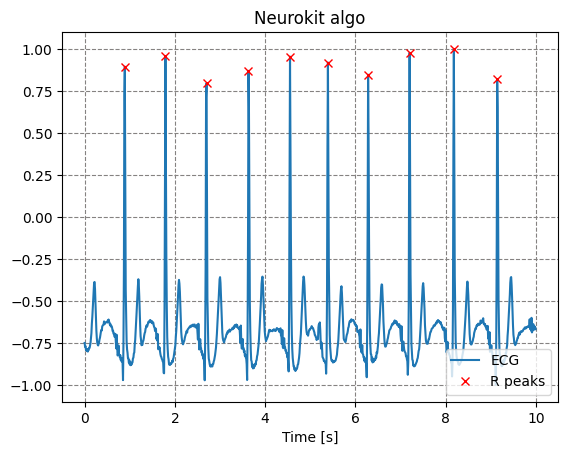

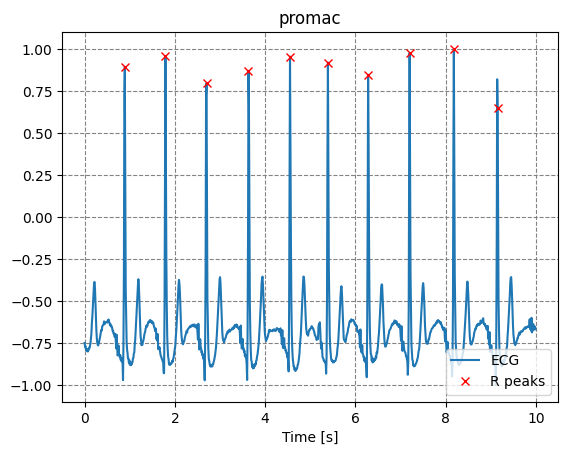

In [6]:
# neurokit2 using neurokit algorithm
sample = norm_min_max(signal=ECGs[88750], lower=-1, upper=1)

r_peaks = detect_nk(ecg_slice=sample, fs=FS)
plot_ecg(signal=sample, r_peaks=r_peaks, title="Neurokit algo")

# or straightforward from neurokit (there are multiple R-peak detection algorithms available)
_, r_peaks = nk.ecg_peaks(ecg_cleaned=sample, sampling_rate=FS, method="promac")
r_peaks = r_peaks['ECG_R_Peaks']

plot_ecg(signal=sample, r_peaks=r_peaks, title="promac")

### WFDB

This library requires adjusting the radius parameter in the find_local_peaks function, which can be quite a challenge when processing tons of ECGs.

In [7]:
import wfdb.processing

hard_peaks, soft_peaks = wfdb.processing.find_peaks(sample)
r_peaks = wfdb.processing.find_local_peaks(sample, radius=50)

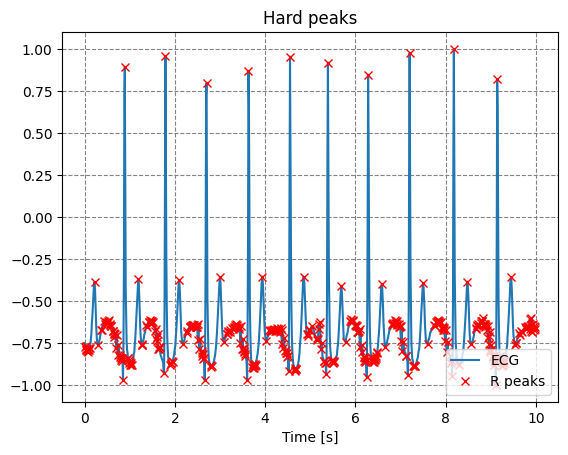

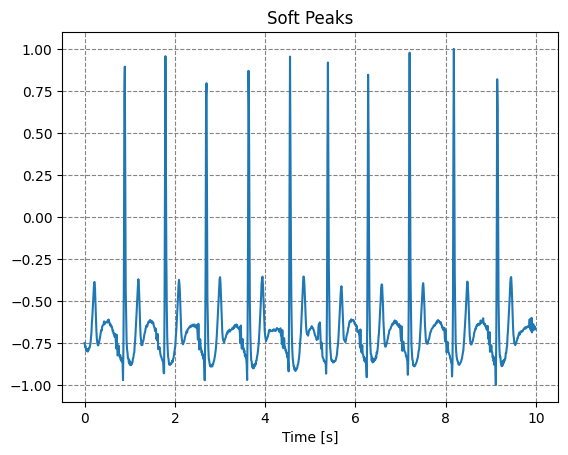

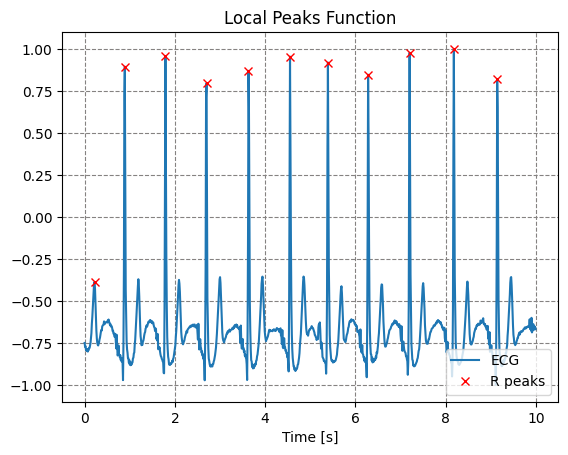

In [8]:
plot_ecg(sample, hard_peaks, title="Hard peaks")
plot_ecg(sample, soft_peaks, title="Soft Peaks")
plot_ecg(sample, r_peaks, title="Local Peaks Function")

### Function for detecting peaks from Medium blog

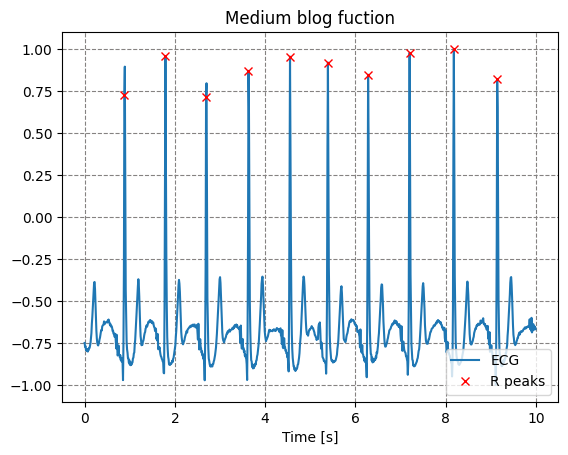

In [9]:
r_peaks = detect_peaks(signal=sample, threshold=0.3)
plot_ecg(sample, r_peaks, title="Medium blog fuction")

### Annotating data with Neurokit2

The Neurokit algorithm is not ideal, however its overall accuracy is sufficient to annotate the ECGs R waves.

When creating the dataset, a significant number of samples are occurring to be faulty. Nevertheless, total amount of ECG windows is high enough for us to discard these samples.

In [10]:
def create_dataset(ecgs, split_ratio=0.25, is_validation_set=False, shuffle=False):
  x = []
  y = []

  print(f"Total ECGs: {ecgs.shape[0]}")
  
  for idx, ecg in tqdm(enumerate(ecgs), total=ecgs.shape[0]):
    try:
      ecg = norm_min_max(signal=ecg, lower=-1, upper=1)
      _, r_peaks = nk.ecg_peaks(ecg, sampling_rate=FS)
      r_peaks_indices = r_peaks["ECG_R_Peaks"]

      r_peaks = np.zeros_like(ecg)
      r_peaks[r_peaks_indices] = 1

      y.append(r_peaks)
      x.append(ecg)
    except Exception as e:
      print(f"Omitting ECG number {idx + 1}")
      print(e)

  total_ecgs = len(x)  

  x = np.array(x)
  y = np.array(y)

  if shuffle:
    indices = np.arange(total_ecgs)
    np.random.shuffle(indices)
    x = x[indices]
    y = y[indices]

  split_idx = int(total_ecgs * (1-split_ratio))

  x_train = np.array(x[:split_idx])
  y_train = np.array(y[:split_idx])

  x_test = np.array(x[split_idx:])
  y_test = np.array(y[split_idx:])


  if(not (os.path.isdir(FINAL_DATASET_PATH))):
    os.mkdir(FINAL_DATASET_PATH)
  
  np.save(os.path.join(FINAL_DATASET_PATH, "x_train.npy"), x_train)
  np.save(os.path.join(FINAL_DATASET_PATH, "y_train.npy"), y_train)
  np.save(os.path.join(FINAL_DATASET_PATH, "x_test.npy"), x_test)
  np.save(os.path.join(FINAL_DATASET_PATH, "y_test.npy"),  y_test)

  if is_validation_set:
    total_x_test_samples = len(x_test)
    val_split_idx = int(total_x_test_samples * 0.5)

    val_indices = np.arange(val_split_idx, dtype=int)
    np.random.shuffle(val_indices)
    val_indices = val_indices[:val_split_idx]

    x_val = x_test[val_indices]
    y_val = y_test[val_indices]

    np.save(os.path.join(FINAL_DATASET_PATH, "x_val.npy"), x_val)
    np.save(os.path.join(FINAL_DATASET_PATH, "y_val.npy"),  y_val)

    return (x_train, y_train, x_test, y_test, x_val, y_val)
  else:
    return (x_train, y_train, x_test, y_test)

In [11]:
x_train, y_train, x_test, y_test, x_val, y_val = create_dataset(ECGs, 0.25, is_validation_set=True, shuffle=True)

Total ECGs: 206517


 25%|██▍       | 50708/206517 [00:52<02:29, 1040.71it/s]c:\Users\patry\OneDrive\Elearning - PG\WETI\masters-thesis\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\patry\OneDrive\Elearning - PG\WETI\masters-thesis\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 25%|██▍       | 50813/206517 [00:52<02:29, 1040.48it/s]

Omitting ECG number 50687
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 50688
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 50689
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 50690
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 50691
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 50692
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 50693
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 50694
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 50797
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 50804
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 50806
index 0 is out of bounds for axis 0 with size 0


 25%|██▍       | 51130/206517 [00:52<02:36, 992.38it/s] 

Omitting ECG number 50956
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 50957
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 50959
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 50960
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 51031
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 51034
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 51035
index 0 is out of bounds for axis 0 with size 0


 32%|███▏      | 66599/206517 [01:08<02:06, 1101.75it/s]

Omitting ECG number 66481
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 66482
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 66483
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 66484
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 66485
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 66486
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 66487
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 66488
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 66489
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 66490
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 66491
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 66492
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 66493
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 66494
index 0 is o

 34%|███▎      | 69399/206517 [01:11<02:03, 1113.51it/s]

Omitting ECG number 69160
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 69161
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 69162
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 69163
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 69164
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 69165
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 69166
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 69167
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 69168
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 69169
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 69170
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 69171
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 69172
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 69173
index 0 is o

 36%|███▌      | 74301/206517 [01:16<02:32, 864.46it/s] c:\Users\patry\OneDrive\Elearning - PG\WETI\masters-thesis\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\patry\OneDrive\Elearning - PG\WETI\masters-thesis\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 36%|███▌      | 74564/206517 [01:16<02:04, 1057.19it/s]

Omitting ECG number 74326
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 74327
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 74328
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 74329
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 74330
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 74331
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 74332
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 74333
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 74334
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 74335
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 74336
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 74337
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 74338
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 74339
index 0 is o

 37%|███▋      | 77355/206517 [01:19<01:56, 1107.78it/s]

Omitting ECG number 77225
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 77226
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 77227
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 77228
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 77229
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 77230
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 77231
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 77232
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 77233
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 77234
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 77235
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 77237
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 77238
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 77239
index 0 is o

 40%|████      | 83196/206517 [01:24<01:41, 1216.26it/s]

Omitting ECG number 82952
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 82953
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 82954
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 82955
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 82956
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 82957
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 82958
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 82959
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 82960
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 82961
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 82962
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 82963
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 82964
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 82965
index 0 is o

 47%|████▋     | 97345/206517 [01:39<01:43, 1053.71it/s]

invalid value encountered in divide
Omitting ECG number 97088
NeuroKit error: signal_smooth(): 'size' should be between 1 and length of the signal.
Omitting ECG number 97089
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 97090
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 97091
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 97092
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 97093
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 97094
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 97095
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 97096
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 97097
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 97098
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 97099
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 97100
index 0 is o

 48%|████▊     | 100011/206517 [01:42<01:42, 1044.08it/s]

Omitting ECG number 99894
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 99895
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 99896
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 99897
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 99898
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 99899
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 99900
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 99901
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 99902
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 99903
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 99904
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 99905
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 99906
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 99907
index 0 is o

 54%|█████▍    | 111366/206517 [01:54<01:41, 932.88it/s] 

Omitting ECG number 111239
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 111240
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 111241
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 111242
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 111243
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 111244
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 111245
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 111246
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 111247
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 111248
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 111249
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 111250
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 111251
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 11125

 57%|█████▋    | 117356/206517 [01:59<01:23, 1074.18it/s]

Omitting ECG number 117157
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 117158
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 117159
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 117160
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 117161
index 0 is out of bounds for axis 0 with size 0
invalid value encountered in divide
Omitting ECG number 117163
NeuroKit error: signal_smooth(): 'size' should be between 1 and length of the signal.
invalid value encountered in divide
Omitting ECG number 117164
NeuroKit error: signal_smooth(): 'size' should be between 1 and length of the signal.
invalid value encountered in divide
Omitting ECG number 117165
NeuroKit error: signal_smooth(): 'size' should be between 1 and length of the signal.
invalid value encountered in divide
Omitting ECG number 117166
NeuroKit error: signal_smooth(): 'size' should be between 1 and length of the signal.
invalid value encountered in 

 67%|██████▋   | 138138/206517 [02:21<01:06, 1035.25it/s]

Omitting ECG number 138010
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 138011
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 138016
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 138019
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 138020
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 138021
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 138022
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 138038
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 138039
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 138041
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 138044
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 138047
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 138048
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 13804

 70%|██████▉   | 144202/206517 [02:27<00:56, 1111.03it/s]

invalid value encountered in divide
Omitting ECG number 144053
NeuroKit error: signal_smooth(): 'size' should be between 1 and length of the signal.
invalid value encountered in divide
Omitting ECG number 144054
NeuroKit error: signal_smooth(): 'size' should be between 1 and length of the signal.
invalid value encountered in divide
Omitting ECG number 144055
NeuroKit error: signal_smooth(): 'size' should be between 1 and length of the signal.
invalid value encountered in divide
Omitting ECG number 144056
NeuroKit error: signal_smooth(): 'size' should be between 1 and length of the signal.
invalid value encountered in divide
Omitting ECG number 144057
NeuroKit error: signal_smooth(): 'size' should be between 1 and length of the signal.
invalid value encountered in divide
Omitting ECG number 144058
NeuroKit error: signal_smooth(): 'size' should be between 1 and length of the signal.
invalid value encountered in divide
Omitting ECG number 144059
NeuroKit error: signal_smooth(): 'size' sho

 74%|███████▍  | 152677/206517 [02:35<00:54, 991.99it/s] c:\Users\patry\OneDrive\Elearning - PG\WETI\masters-thesis\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\patry\OneDrive\Elearning - PG\WETI\masters-thesis\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 74%|███████▍  | 152980/206517 [02:35<00:45, 1174.75it/s]

invalid value encountered in divide
Omitting ECG number 152724
NeuroKit error: signal_smooth(): 'size' should be between 1 and length of the signal.
invalid value encountered in divide
Omitting ECG number 152725
NeuroKit error: signal_smooth(): 'size' should be between 1 and length of the signal.
invalid value encountered in divide
Omitting ECG number 152726
NeuroKit error: signal_smooth(): 'size' should be between 1 and length of the signal.
invalid value encountered in divide
Omitting ECG number 152733
NeuroKit error: signal_smooth(): 'size' should be between 1 and length of the signal.
invalid value encountered in divide
Omitting ECG number 152734
NeuroKit error: signal_smooth(): 'size' should be between 1 and length of the signal.
invalid value encountered in divide
Omitting ECG number 152736
NeuroKit error: signal_smooth(): 'size' should be between 1 and length of the signal.
invalid value encountered in divide
Omitting ECG number 152737
NeuroKit error: signal_smooth(): 'size' sho

 75%|███████▌  | 155619/206517 [02:38<00:52, 969.29it/s] 

invalid value encountered in divide
Omitting ECG number 155492
NeuroKit error: signal_smooth(): 'size' should be between 1 and length of the signal.


 77%|███████▋  | 159727/206517 [02:42<00:43, 1071.25it/s]

Omitting ECG number 159485
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 159486
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 159487
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 159488
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 159490
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 159491
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 159492
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 159494
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 159495
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 159497
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 159502
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 159503
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 159506
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 15950

 80%|███████▉  | 164696/206517 [02:47<00:36, 1131.13it/s]

Omitting ECG number 164568
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 164569
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 164570
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 164571
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 164572
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 164573
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 164574
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 164575
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 164576
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 164577
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 164578
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 164579
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 164580
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 16458

 83%|████████▎ | 170852/206517 [02:53<00:31, 1150.29it/s]

Omitting ECG number 170651
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 170652
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 170653
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 170654
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 170655
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 170656
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 170657
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 170658
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 170659
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 170660
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 170661
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 170662
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 170663
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 17066

 90%|████████▉ | 185356/206517 [03:08<00:21, 999.59it/s] c:\Users\patry\OneDrive\Elearning - PG\WETI\masters-thesis\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\patry\OneDrive\Elearning - PG\WETI\masters-thesis\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 90%|████████▉ | 185466/206517 [03:08<00:20, 1027.70it/s]

Omitting ECG number 185351
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 185352
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 185353
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 185355
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 185356
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 185357
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 185358
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 185359
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 185360
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 185361
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 185362
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 185363
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 185364
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 18536

 91%|█████████ | 188299/206517 [03:11<00:18, 971.25it/s] 

invalid value encountered in divide
Omitting ECG number 188171
NeuroKit error: signal_smooth(): 'size' should be between 1 and length of the signal.


 93%|█████████▎| 191442/206517 [03:14<00:12, 1165.85it/s]

Omitting ECG number 191236
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 191237
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 191238
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 191239
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 191240
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 191250
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 191251
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 191252
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 191253
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 191254
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 191255
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 191261
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 191272
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 19128

 96%|█████████▌| 198071/206517 [03:21<00:09, 931.27it/s] 

invalid value encountered in divide
Omitting ECG number 197942
NeuroKit error: signal_smooth(): 'size' should be between 1 and length of the signal.
invalid value encountered in divide
Omitting ECG number 197943
NeuroKit error: signal_smooth(): 'size' should be between 1 and length of the signal.
invalid value encountered in divide
Omitting ECG number 197944
NeuroKit error: signal_smooth(): 'size' should be between 1 and length of the signal.
invalid value encountered in divide
Omitting ECG number 197945
NeuroKit error: signal_smooth(): 'size' should be between 1 and length of the signal.


 99%|█████████▊| 203829/206517 [03:27<00:02, 1063.79it/s]

Omitting ECG number 203625
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 203626
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 203627
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 203628
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 203629
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 203630
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 203631
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 203632
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 203633
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 203634
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 203635
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 203636
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 203637
index 0 is out of bounds for axis 0 with size 0
Omitting ECG number 20363

100%|██████████| 206517/206517 [03:30<00:00, 983.10it/s] 


In [13]:
print("Train data: \nX - ", x_train.shape, "\nY - ", y_train.shape)
print()
print("Test data: \nX - ", x_test.shape, "\nY - ", y_test.shape)
print()
print("Validation data: \nX - ", x_val.shape, "\nY - ", y_val.shape)

Train data: 
X -  (154131, 1000) 
Y -  (154131, 1000)

Test data: 
X -  (51378, 1000) 
Y -  (51378, 1000)

Validation data: 
X -  (25689, 1000) 
Y -  (25689, 1000)
